# INFOMCDMMC Critical Data Mining of Media Culture

## Utrecht University, MSc Applied Data Science


### Team members:
* Meagan Loerakker, m.b.loerakker@students.uu.nl
* Celesta Terwisscha van Scheltinga, c.c.m.terwisschavanscheltinga@students.uu.nl
* Nina Alblas, n.m.alblas@students.uu.nl
* Berber van Drunen, b.p.vandrunen@students.uu.nl
* Debarupa Roy Choudhury, d.roychoudhury@students.uu.nl

# Sentiment analysis with VADER

In [ ]:
! pip install vaderSentiment

#Stats
import pandas as pd

#Support
import re
import csv
import string

#Visualisation
import matplotlib.pyplot as plt

# Vader library
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


In [30]:
# load data
news_ai_df = pd.read_csv("data/preprocessed_data.csv").iloc[:, 1:]
news_ai_df

,filename,outlet,title,description,datetime,body,year,month,preprocessed_description,preprocessed_body
0,2010-06-gears-of-war-3-beast.html,Wired,Gears of War 3 Co-op Makes Beasts of Gamers,"LOS ANGELES — Back in 2008, Gears of War 2 int...",2010-06-17 16:22:00.000,"LOS ANGELES – Back in 2008, Gears of War 2 in...",2010,6,los angeles gear war introduced horde mode co ...,los angeles gear war introduced horde mode co ...
1,sponsored-story-innovating-for-the-individual....,Wired,WIRED Brand Lab | Innovating for the Individual,What every leader can learn from the technolog...,2021-08-27 12:14:31.296,Innovative technology is making healthcare mor...,2021,8,leader learn transforming healthcare,innovative making healthcare personal bit inge...
2,ttps:--www.wired.com-story-for-all-mankind-bes...,Wired,‘For All Mankind’ Is the Best Sci-Fi of Its Era,The Apple TV+ alternate history series is simp...,2022-06-09 07:00:00.000,"New Star Wars, new Star Trek, Russian Doll, Se...",2022,6,apple tv alternate history series ambitious th...,new star war new star trek russian doll severa...
3,story-ghostery-open-source-new-business-model....,Wired,Ad-Blocker Ghostery Just Went Open Source—And ...,"Ghostery, Edward Snowden’s preferred ad-blocke...",2018-03-08 09:45:00.000,"In privacy-focused, anti-establishment corners...",2018,3,ghostery edward snowden preferred ad blocker d...,privacy focused anti establishment corner inte...
4,story-best-game-subscriptions.html,Wired,Too Many Game Subscription Services? Here’s Ho...,PlayStation Plus Extra or Plus Premium? Xbox L...,2022-04-11 10:00:00.000,Gaming is starting to look more and more like...,2022,4,playstation extra plus premium xbox live gold ...,gaming starting look netflix buying disc store...
...,...,...,...,...,...,...,...,...,...,...
17427,bits.blogs.nytimes.com-2014-01-01-big-data-shr...,NYT,Big Data Shrinks to Grow,It was a good year for Big Data — the term at ...,2014-01-01 16:00:55.000,"In fact, it may be underway. Google Trends sh...",2014,1,good big data term least industry mass data su...,fact underway google trend show search term bi...
17428,2013-06-09-us-revelations-give-look-at-spy-age...,NYT,How the U.S. Uses Technology to Mine More Data...,A revolution in software technology has transf...,2013-06-09 01:43:16.000,WASHINGTON — When American analysts hunting te...,2013,6,revolution software transformed national secur...,american analyst hunting terrorist sought new ...
17429,krugman.blogs.nytimes.com-2013-08-18-the-dynam...,NYT,The Dynamo and Big Data,These things take time.,2013-08-18 15:43:43.000,James Glanz relays skepticism about the econom...,2013,8,thing take,james glanz relay skepticism economic impact b...
17430,dealbook.nytimes.com-2012-03-26-morning-take-o...,NYT,Morning Take-Out,Highlights from the DealBook newsletter.,2012-03-26 14:23:58.000,E-Mail to Corzine Said Transfer Was Not Custom...,2012,3,highlight dealbook newsletter,e mail corzine transfer customer money jon cor...


In [31]:
# remove the new NaNs
news_ai_df = news_ai_df.dropna()

In [32]:
def sentiment_barplot(data, group_by_col, sentiment_col, article_section="description", log_scale=False, normalize=False, file_name="barplot.png"):
    """
    Takes a DataFrame and creates a bar plot that shows the distribution
    of the sentiment assigned by the analyzer among the different values 
    of the column 'group_by_col'.
    
    data : pd.DataFrame
    group_by_col : column name / string
    sentiment_col : column name / string
    article_section : string ("description" or "body")
    log_scale : bool
    normalize : bool
    
    """

    # create a DataFrame with the outlets as rows and the sentiment values as columns
    sentiment_per_col_value = data.groupby([group_by_col, sentiment_col]).count().iloc[:, 0].unstack()
    
    if normalize:
        
        # divide a frequency by the total number of articles from its outlet
        articles_per_col_value = sentiment_per_col_value.sum(axis=1)
        sentiment_per_col_value = sentiment_per_col_value.div(articles_per_col_value, axis=0)
        
        plot_title = f"Article {article_section} VADER sentiments per {group_by_col}\n(normalized counts)"
        
    else:
        plot_title = f"Article {article_section} VADER sentiments per {group_by_col}"
        
    if log_scale:
        y_label = "frequency (log)"
    else:
        y_label = "frequency"
    
    # create the bar plot
    sentiment_per_col_value.plot(kind="bar",
                                 logy=log_scale,
                                 colormap="winter",
                                 ylabel=y_label,
                                 title=plot_title)
    
    plt.legend(title="sentiment")
    plt.savefig(f"plots/{file_name}", bbox_inches="tight")

In [33]:
def vader_sentiment(text):
    """
    Use a SentimentIntensityAnalyzer from the vaderSentiment library
    to assign a sentiment to the inputted text.
    """

    sia_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sia_obj.polarity_scores(text)
    
    sent_score = sentiment_dict['compound']

    # Typical cut off points (https://github.com/cjhutto/vaderSentiment#python-demo-and-code-examples)
    # Also source: https://www.twinword.com/blog/interpreting-the-score-and-ratio-of-sentiment/
    # If the sentiment is 0.05 or higher, we give it a positive sentiment; -0.05 or lower is a negative sentiment
    if sent_score >= 0.05:
        sentiment = 1

    elif sent_score <= - 0.05:
        sentiment = -1

    else:
        sentiment = 0

    return sentiment

#### Article descriptions

In [34]:
# apply vader to descriptions
news_ai_df["vader_desc_sentiment"] = news_ai_df["preprocessed_description"].apply(lambda text : vader_sentiment(text))
news_ai_df

/Users/ninaalblas/opt/anaconda3/envs/proglab/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,filename,outlet,title,description,datetime,body,year,month,preprocessed_description,preprocessed_body,vader_desc_sentiment
0,2010-06-gears-of-war-3-beast.html,Wired,Gears of War 3 Co-op Makes Beasts of Gamers,"LOS ANGELES — Back in 2008, Gears of War 2 int...",2010-06-17 16:22:00.000,"LOS ANGELES – Back in 2008, Gears of War 2 in...",2010,6,los angeles gear war introduced horde mode co ...,los angeles gear war introduced horde mode co ...,0
1,sponsored-story-innovating-for-the-individual....,Wired,WIRED Brand Lab | Innovating for the Individual,What every leader can learn from the technolog...,2021-08-27 12:14:31.296,Innovative technology is making healthcare mor...,2021,8,leader learn transforming healthcare,innovative making healthcare personal bit inge...,0
2,ttps:--www.wired.com-story-for-all-mankind-bes...,Wired,‘For All Mankind’ Is the Best Sci-Fi of Its Era,The Apple TV+ alternate history series is simp...,2022-06-09 07:00:00.000,"New Star Wars, new Star Trek, Russian Doll, Se...",2022,6,apple tv alternate history series ambitious th...,new star war new star trek russian doll severa...,1
3,story-ghostery-open-source-new-business-model....,Wired,Ad-Blocker Ghostery Just Went Open Source—And ...,"Ghostery, Edward Snowden’s preferred ad-blocke...",2018-03-08 09:45:00.000,"In privacy-focused, anti-establishment corners...",2018,3,ghostery edward snowden preferred ad blocker d...,privacy focused anti establishment corner inte...,-1
4,story-best-game-subscriptions.html,Wired,Too Many Game Subscription Services? Here’s Ho...,PlayStation Plus Extra or Plus Premium? Xbox L...,2022-04-11 10:00:00.000,Gaming is starting to look more and more like...,2022,4,playstation extra plus premium xbox live gold ...,gaming starting look netflix buying disc store...,1
...,...,...,...,...,...,...,...,...,...,...,...
17427,bits.blogs.nytimes.com-2014-01-01-big-data-shr...,NYT,Big Data Shrinks to Grow,It was a good year for Big Data — the term at ...,2014-01-01 16:00:55.000,"In fact, it may be underway. Google Trends sh...",2014,1,good big data term least industry mass data su...,fact underway google trend show search term bi...,1
17428,2013-06-09-us-revelations-give-look-at-spy-age...,NYT,How the U.S. Uses Technology to Mine More Data...,A revolution in software technology has transf...,2013-06-09 01:43:16.000,WASHINGTON — When American analysts hunting te...,2013,6,revolution software transformed national secur...,american analyst hunting terrorist sought new ...,1
17429,krugman.blogs.nytimes.com-2013-08-18-the-dynam...,NYT,The Dynamo and Big Data,These things take time.,2013-08-18 15:43:43.000,James Glanz relays skepticism about the econom...,2013,8,thing take,james glanz relay skepticism economic impact b...,0
17430,dealbook.nytimes.com-2012-03-26-morning-take-o...,NYT,Morning Take-Out,Highlights from the DealBook newsletter.,2012-03-26 14:23:58.000,E-Mail to Corzine Said Transfer Was Not Custom...,2012,3,highlight dealbook newsletter,e mail corzine transfer customer money jon cor...,1


We'll sort the data and check if the sentiment results of the first 10 negative, neutral, and positive records make sense

In [35]:
# ensure description text is not truncated
pd.set_option('display.max_colwidth', None)

display(news_ai_df[['description', 'vader_desc_sentiment']].sort_values("vader_desc_sentiment").groupby("vader_desc_sentiment").head(5))

# set max display column width back to default value
pd.set_option('display.max_colwidth', 50)

,description,vader_desc_sentiment
13244,"Apple has Siri. Microsoft has Cortana. Google has Google Now. Now, Facebook is hopping on the AI assistant bandwagon with M. Not to be confused with fictional head of the MI6, M is a personal assistant baked right into Messenger that serves up information when you ask for it.",-1
13458,The death of a founder of the field of artificial intelligence.,-1
8909,"In Mamoru Hosoda’s anime feature “Summer Wars,” Oz is a global virtual reality.",-1
4159,"A new book describes how a Mechanical Turker used alarms and shortcuts to make $20 an hour, at the cost of her health.",-1
4155,"The critical vulnerability is buried among endless open source code, and many cyber experts are stumped.",-1
13938,"Using what one expert calls a ‘Wizard of Oz technique’, some companies keep their reliance on humans a secret from investors",0
12154,"The chairman of IAC and husband of Diane von Furstenberg reflects on pornography, philanthropy and the end of Hollywood as we knew it.",0
12240,Here’s what you need to know to start your day.,0
12396,Here’s what you need to know at the end of the day.,0
12027,"Our Toronto bureau chief talks about her searing experiences in Haiti, and Broadway producers find a congenial tryout spot in Edmonton.",0


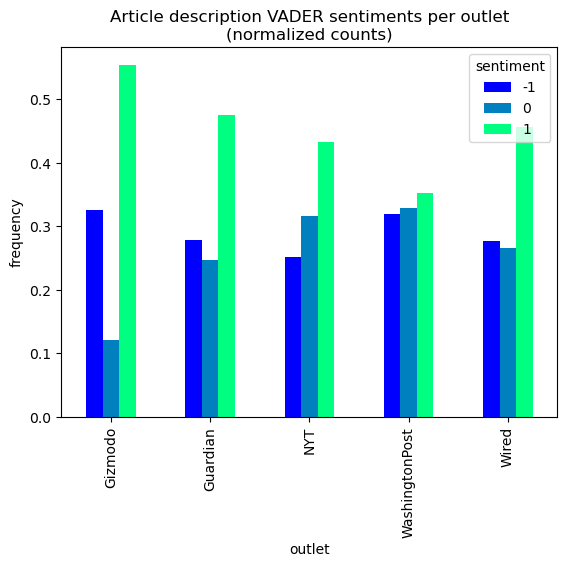

In [36]:
# Create a normalized bar plot of the description sentiments per news outlet
sentiment_barplot(news_ai_df, 
                  group_by_col="outlet", 
                  sentiment_col="vader_desc_sentiment", 
                  normalize=True, 
                  file_name="vader_desc_barplot.png")

#### Article bodies

In [42]:
# apply vader to bodies
news_ai_df["vader_body_sentiment"] = news_ai_df["preprocessed_body"].apply(lambda text : vader_sentiment(text))
news_ai_df

/Users/ninaalblas/opt/anaconda3/envs/proglab/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,filename,outlet,title,description,datetime,body,year,month,preprocessed_description,preprocessed_body,vader_desc_sentiment,vader_body_sentiment
0,2010-06-gears-of-war-3-beast.html,Wired,Gears of War 3 Co-op Makes Beasts of Gamers,"LOS ANGELES — Back in 2008, Gears of War 2 int...",2010-06-17 16:22:00.000,"LOS ANGELES – Back in 2008, Gears of War 2 in...",2010,6,los angeles gear war introduced horde mode co ...,los angeles gear war introduced horde mode co ...,0,-1
1,sponsored-story-innovating-for-the-individual....,Wired,WIRED Brand Lab | Innovating for the Individual,What every leader can learn from the technolog...,2021-08-27 12:14:31.296,Innovative technology is making healthcare mor...,2021,8,leader learn transforming healthcare,innovative making healthcare personal bit inge...,0,1
2,ttps:--www.wired.com-story-for-all-mankind-bes...,Wired,‘For All Mankind’ Is the Best Sci-Fi of Its Era,The Apple TV+ alternate history series is simp...,2022-06-09 07:00:00.000,"New Star Wars, new Star Trek, Russian Doll, Se...",2022,6,apple tv alternate history series ambitious th...,new star war new star trek russian doll severa...,1,1
3,story-ghostery-open-source-new-business-model....,Wired,Ad-Blocker Ghostery Just Went Open Source—And ...,"Ghostery, Edward Snowden’s preferred ad-blocke...",2018-03-08 09:45:00.000,"In privacy-focused, anti-establishment corners...",2018,3,ghostery edward snowden preferred ad blocker d...,privacy focused anti establishment corner inte...,-1,1
4,story-best-game-subscriptions.html,Wired,Too Many Game Subscription Services? Here’s Ho...,PlayStation Plus Extra or Plus Premium? Xbox L...,2022-04-11 10:00:00.000,Gaming is starting to look more and more like...,2022,4,playstation extra plus premium xbox live gold ...,gaming starting look netflix buying disc store...,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
17427,bits.blogs.nytimes.com-2014-01-01-big-data-shr...,NYT,Big Data Shrinks to Grow,It was a good year for Big Data — the term at ...,2014-01-01 16:00:55.000,"In fact, it may be underway. Google Trends sh...",2014,1,good big data term least industry mass data su...,fact underway google trend show search term bi...,1,1
17428,2013-06-09-us-revelations-give-look-at-spy-age...,NYT,How the U.S. Uses Technology to Mine More Data...,A revolution in software technology has transf...,2013-06-09 01:43:16.000,WASHINGTON — When American analysts hunting te...,2013,6,revolution software transformed national secur...,american analyst hunting terrorist sought new ...,1,1
17429,krugman.blogs.nytimes.com-2013-08-18-the-dynam...,NYT,The Dynamo and Big Data,These things take time.,2013-08-18 15:43:43.000,James Glanz relays skepticism about the econom...,2013,8,thing take,james glanz relay skepticism economic impact b...,0,-1
17430,dealbook.nytimes.com-2012-03-26-morning-take-o...,NYT,Morning Take-Out,Highlights from the DealBook newsletter.,2012-03-26 14:23:58.000,E-Mail to Corzine Said Transfer Was Not Custom...,2012,3,highlight dealbook newsletter,e mail corzine transfer customer money jon cor...,1,1


We'll sort the data and check if the sentiment results of the first 10 negative, neutral, and positive records make sense

In [43]:
# ensure description text is not truncated
pd.set_option('display.max_colwidth', None)

display(news_ai_df[['body', 'vader_body_sentiment']].sort_values("vader_body_sentiment").groupby("vader_body_sentiment").head(5))

# set max display column width back to default value
pd.set_option('display.max_colwidth', 50)

body  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

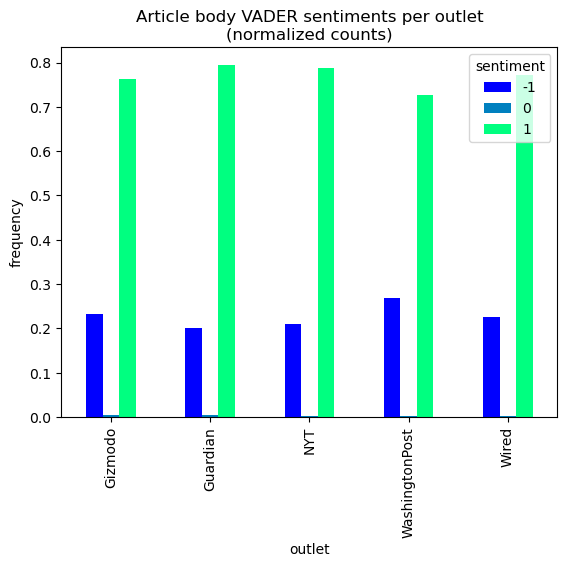

In [44]:
# Create a normalized bar plot of the body sentiments per news outlet
sentiment_barplot(news_ai_df, 
                  group_by_col="outlet", 
                  article_section="body",
                  sentiment_col="vader_body_sentiment", 
                  normalize=True, 
                  file_name="vader_body_barplot.png")

In [45]:
# save new df including vader sentiments as csv
news_ai_df.to_csv("data/vader_sentiments.csv")

### Sentiment over the years in general news

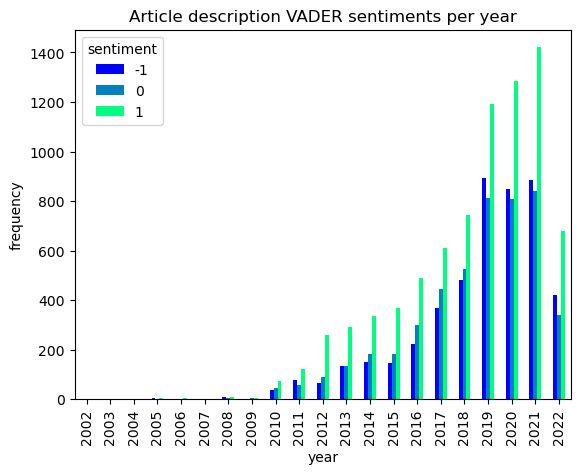

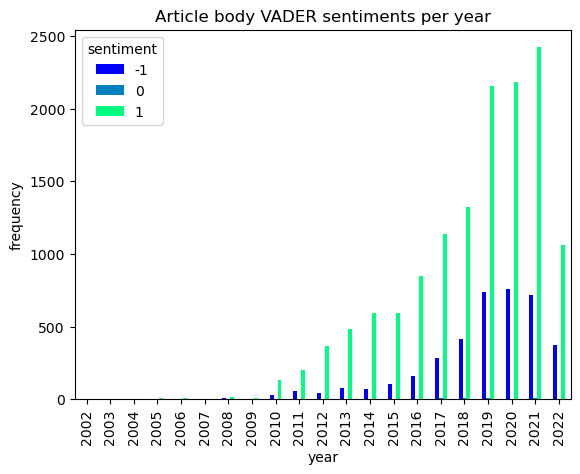

In [46]:
# vader - descriptions
sentiment_barplot(news_ai_df, 
                  group_by_col="year", 
                  sentiment_col="vader_desc_sentiment",
                  file_name="vader_desc_sent_by_year.png")

# vader - bodies
sentiment_barplot(news_ai_df, 
                  group_by_col="year", 
                  article_section="body",
                  sentiment_col="vader_body_sentiment",
                  file_name="vader_body_sent_by_year.png")